# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    #add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    #add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths# + add_train_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'])
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict, strict=False)
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [10]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [11]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-03-30 14:29:32,004 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-03-30 14:29:32,006 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 14:29:32,007 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:25<00:00, 17.06s/it]
2021-03-30 14:38:02,303 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/fan_features.pkl
2021-03-30 14:38:02,305 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-03-30 14:38:02,306 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 14:38:02,307 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 510.299713850 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 6/6 [01:40<00:00, 16.70s/it]
2021-03-30 14:47:53,541 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/gearbox_features.pkl
2021-03-30 14:47:53,544 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-03-30 14:47:53,544 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 14:47:53,545 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 591.236791849 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:29<00:00, 17.80s/it]
2021-03-30 14:57:22,979 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/pump_features.pkl
2021-03-30 14:57:22,982 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-03-30 14:57:22,982 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 14:57:22,983 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 569.436532021 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:19<00:00, 15.90s/it]
2021-03-30 15:05:49,661 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/slider_features.pkl
2021-03-30 15:05:49,668 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-03-30 15:05:49,669 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 15:05:49,670 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 506.680615425 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:16<00:00, 15.32s/it]
2021-03-30 15:14:01,923 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/ToyCar_features.pkl
2021-03-30 15:14:01,925 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-03-30 15:14:01,926 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 15:14:01,927 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 492.255701303 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:26<00:00, 17.23s/it]
2021-03-30 15:23:14,886 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/ToyTrain_features.pkl
2021-03-30 15:23:14,888 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-03-30 15:23:14,889 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-30 15:23:14,892 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 552.961301088 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [01:18<00:00, 15.70s/it]
2021-03-30 15:31:18,881 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_res_sr32k/extraction_features/valve_features.pkl


elapsed time: 483.993511915 [sec]


In [12]:
machine_type = 'pump'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

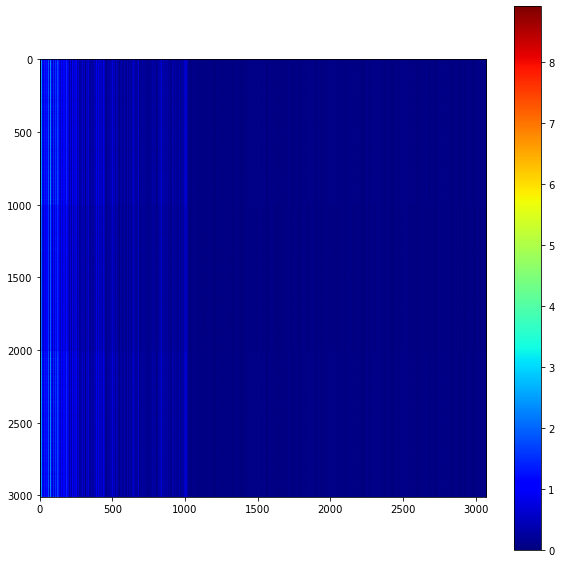

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

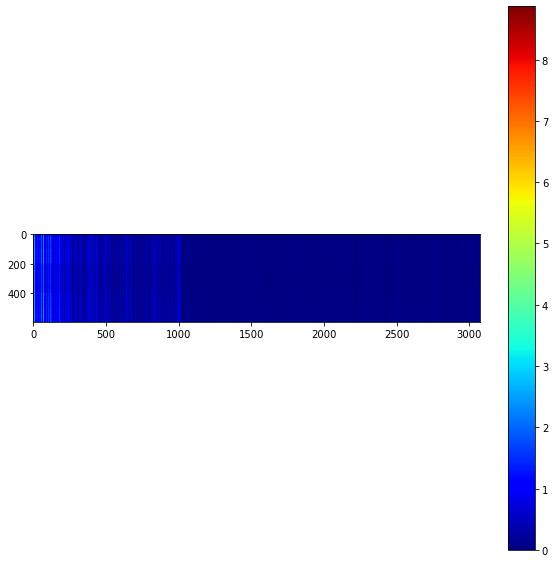

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_source']['features'], cmap='jet')
plt.colorbar()

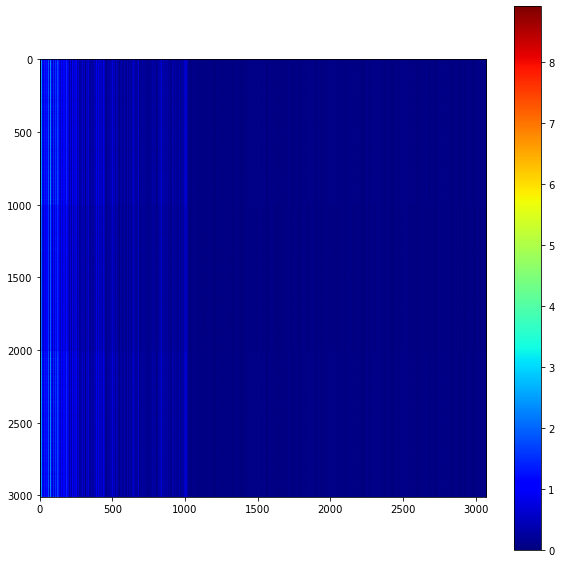

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)

In [16]:
print(M_means.shape)
plt.imshow(M_means, aspect='auto', cmap='jet')
plt.title(phase)
plt.colorbar()
plt.show()

NameError: name 'M_means' is not defined